<a href="https://colab.research.google.com/github/DrSubbiah/1.Bayesian-Inference/blob/master/A_Simple_Hamiltonian_Monte_Carlo_Example_with_TensorFlow_Probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Viz.
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid',
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')

TnesorFlow version: 2.8.2
TnesorFlow Probability version: 0.16.0


In [ ]:
tf.random.set_seed(seed=42)
# Number of samples.
n = 100
# True rate parameter.
rate_true = 2.0
# Define Poisson distribution with the true rate parameter.
poisson_true = tfd.Poisson(rate=rate_true)
# Generate samples.
poisson_samples = poisson_true.sample(sample_shape=n)
poisson_samples

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0., 1., 4., 1., 2., 1., 3., 1., 2., 2., 0., 0., 3., 1., 2., 1., 2.,
       1., 1., 1., 1., 3., 1., 3., 1., 2., 2., 4., 2., 1., 2., 2., 0., 2.,
       0., 1., 3., 3., 1., 1., 2., 2., 6., 0., 1., 1., 1., 3., 2., 3., 1.,
       3., 1., 0., 2., 3., 1., 1., 3., 2., 3., 2., 1., 2., 3., 0., 2., 4.,
       1., 2., 2., 0., 3., 4., 1., 3., 1., 1., 2., 2., 2., 3., 1., 2., 3.,
       1., 1., 1., 0., 2., 2., 1., 5., 2., 2., 4., 0., 2., 2., 3.],
      dtype=float32)>

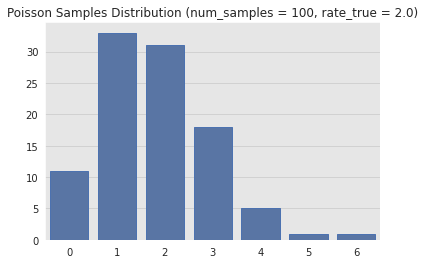

In [ ]:
y_range, idy, c = tf.unique_with_counts(poisson_samples)

fig, ax = plt.subplots()
sns.barplot(x=y_range.numpy(), y=c.numpy(), color=sns_c[0], edgecolor=sns_c[0], ax=ax)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set(title=f'Poisson Samples Distribution (num_samples = {n}, rate_true = {rate_true})');

In [ ]:
# Define parameters for the prior distribution.
a = 4.5
b = 2
# Define prior distribution.
gamma_prior = tfd.Gamma(concentration=a, rate=b)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


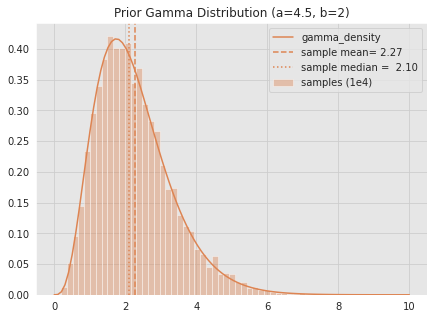

In [ ]:
# Generate samples.
gamma_prior_samples = gamma_prior.sample(sample_shape=1e4)
# Plot.
fig, ax = plt.subplots(figsize=(7, 5))
# Domain to plot.
x = np.linspace(start=0, stop=10, num=100)
# Plot samples distribution.
sns.distplot(
    a=gamma_prior_samples,
    color=sns_c[1],
    kde=False,
    norm_hist=True,
    label='samples (1e4)',
    ax=ax
)
# Plot density function of the gamma density.
sns.lineplot(
    x=x,
    y=ss.gamma.pdf(x, a=a, scale=1/b),
    color=sns_c[1],
    label='gamma_density',
    ax=ax
)
# Some Stats.
sample_mean = tf.reduce_mean(gamma_prior_samples)
sample_median = tfp.stats.percentile(x=gamma_prior_samples, q=50)

ax.axvline(
    x=sample_mean,
    color=sns_c[1],
    linestyle='--',
    label=f'sample mean={sample_mean: 0.2f}'
)

ax.axvline(
    x=sample_median,
    color=sns_c[1],
    linestyle=':',
    label=f'sample median = {sample_median: 0.2f}'
)

ax.legend()
ax.set(title=f'Prior Gamma Distribution (a={a}, b={b})');

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


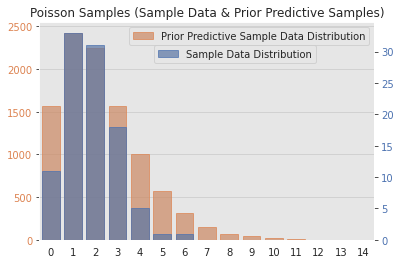

In [ ]:
y_prior_pred = tfd.Poisson(rate=gamma_prior_samples).sample(1)
y_prior_pred  = tf.reshape(y_prior_pred, [-1])

y_range_prior, idy_prior, c_prior = tf.unique_with_counts(y_prior_pred)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.barplot(
    x=y_range.numpy(),
    y=c.numpy(),
    color=sns_c[0],
    edgecolor=sns_c[0],
    alpha=0.7,
    label='Sample Data Distribution',
    ax=ax2
)
sns.barplot(
    x=y_range_prior.numpy(),
    y=c_prior.numpy(),
    color=sns_c[1],
    edgecolor=sns_c[1],
    label='Prior Predictive Sample Data Distribution',
    alpha=0.7,
    ax=ax1
)
ax1.set(title=f'Poisson Samples (Sample Data & Prior Predictive Samples)')
ax1.tick_params(axis='y', labelcolor=sns_c[1])
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc='upper right')
ax2.grid(None)
ax2.legend(bbox_to_anchor=(0.84, 0.92))
ax2.tick_params(axis='y', labelcolor=sns_c[0])

In [ ]:
# First we set the model specification.
def build_model(a=4.5, b=2):
    # Prior Distribution.
    rate = tfd.Gamma(concentration=a, rate=b)
    # Likelihood: Independent samples of a Poisson distribution.
    observations = lambda rate: tfd.Sample(
        distribution=tfd.Poisson(rate=rate),
        sample_shape=len(poisson_samples)
    )
    return tfd.JointDistributionNamed(dict(rate=rate, obs=observations))

# We set the joint-log-probability as the target variable we want to maximize.
def target_log_prob_fn(rate):
    model = build_model()
    return model.log_prob(rate=rate, obs=poisson_samples)

In [ ]:
# Define rates range.
rates = np.linspace(start=0.01, stop=10.0, num=1000)

# Compute joint-log-probability.
model_log_probs = np.array([
    target_log_prob_fn(rate).numpy()
    for rate in rates
])

# Get rate which maximizes the log-probability of the model.
log_prob_maximizer = rates[np.argmax(model_log_probs)]

# Plot the results.
fig, ax = plt.subplots()
sns.lineplot(x=rates, y=model_log_probs, color=sns_c[0], label='model_log_prob', ax=ax)
ax.axvline(x=rate_true, linestyle='--', color=sns_c[3], label=f'rate_true = {rate_true: 0.2f}')
ax.axvline(x=log_prob_maximizer , linestyle='--', color=sns_c[1], label=f'log-prob-maximizer: {log_prob_maximizer: 0.2f}')
ax.legend(loc='upper right')
ax.set(title='Model Log Probability', xlabel='rate', ylabel='log probability');

In [ ]:
# Size of each chain.
num_results = int(1e4)
# Burn-in steps.
num_burnin_steps = int(1e3)
# Hamiltonian Monte Carlo transition kernel.
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3

)
# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)
# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=1.0,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples

In [ ]:
# Set number of chains.
num_chains = 5
# Run sampling.
chains = [run_chain() for i in range(num_chains)]

In [ ]:
# We store the samples in a pandas dataframe.
chains_df = pd.DataFrame([t.numpy() for t in chains])
chains_df = chains_df.T.melt(var_name='chain_id', value_name='sample')
chains_df.head()

,chain_id,sample
0,0,1.947528
1,0,1.971820
2,0,2.057147
3,0,2.057147
4,0,2.057147


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

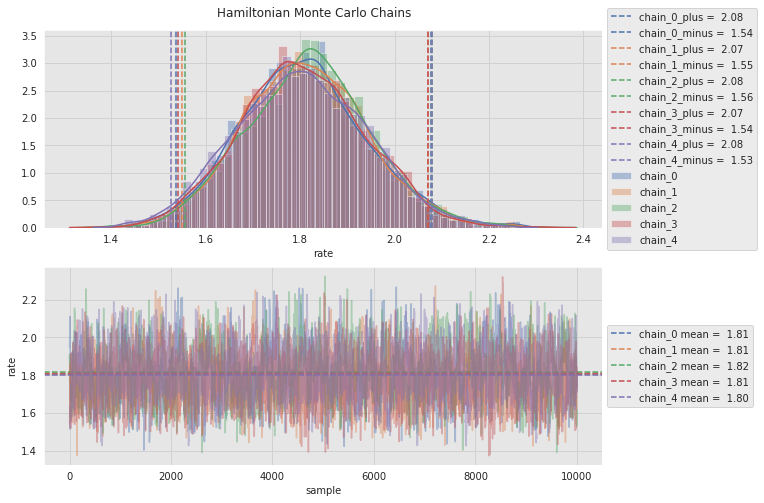

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

for i in range(5):
    chain_samples = chains_df \
        .query(f'chain_id == {i}') \
        .reset_index(drop=True) \
        ['sample']

    chain_samples_mean = chain_samples.mean()
    chain_samples_std = chain_samples.std()
    chain_samples_plus = chain_samples_mean + 2*chain_samples_std
    chain_samples_minus = chain_samples_mean - 2*chain_samples_std

    sns.distplot(a=chain_samples, color=sns_c[i], hist_kws={'alpha': 0.4}, label=f'chain_{i}', ax=ax[0])
    ax[0].axvline(x=chain_samples_plus, linestyle='--', color=sns_c[i], label=f'chain_{i}_plus = {chain_samples_plus: 0.2f}')
    ax[0].axvline(x=chain_samples_minus, linestyle='--', color=sns_c[i], label=f'chain_{i}_minus = {chain_samples_minus: 0.2f}')
    ax[1].plot(chain_samples, c=sns_c[i], alpha=0.4)
    ax[1].axhline(y=chain_samples_mean, linestyle='--', color=sns_c[i], label=f'chain_{i} mean = {chain_samples_mean: 0.2f}')

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set(xlabel='rate', ylabel='')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set(xlabel='sample', ylabel='rate')
plt.suptitle('Hamiltonian Monte Carlo Chains', y=0.92);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


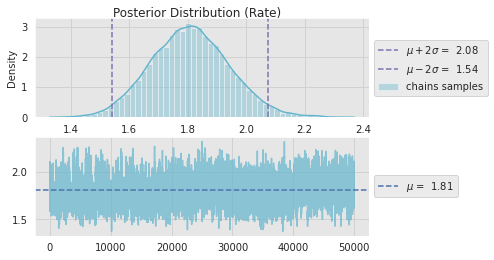

In [ ]:
fig, ax = plt.subplots(2, 1)

chain_samples = chains_df['sample']
chain_samples_mean = chain_samples.mean()
chain_samples_std = chain_samples.std()
chain_samples_plus = chain_samples_mean + 2*chain_samples_std
chain_samples_minus = chain_samples_mean - 2*chain_samples_std

sns.distplot(a=chain_samples, color=sns_c[9], label=f'chains samples', ax=ax[0])
ax[0].axvline(x=chain_samples_plus, linestyle='--', color=sns_c[4], label=f'$\mu + 2\sigma$ = {chain_samples_plus: 0.2f}')
ax[0].axvline(x=chain_samples_minus, linestyle='--', color=sns_c[4], label=f'$\mu - 2\sigma$ = {chain_samples_minus: 0.2f}')
ax[1].plot(chain_samples, c=sns_c[9], alpha=0.7)
ax[1].axhline(y=chain_samples_mean, linestyle='--', color=sns_c[0], label=f'$\mu$ = {chain_samples_mean: 0.2f}')

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle(f'Posterior Distribution (Rate)', y=0.92);

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


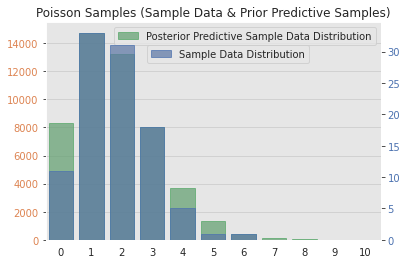

In [ ]:
y_post_pred = tfd.Poisson(rate=chains_df['sample']).sample(1)
y_post_pred  = tf.reshape(y_post_pred, [-1])

y_range_prior, idy_prior, c_prior = tf.unique_with_counts(y_post_pred)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.barplot(
    x=y_range.numpy(),
    y=c.numpy(),
    color=sns_c[0],
    edgecolor=sns_c[0],
    alpha=0.7,
    label='Sample Data Distribution',
    ax=ax2
)
sns.barplot(
    x=y_range_prior.numpy(),
    y=c_prior.numpy(),
    color=sns_c[2],
    edgecolor=sns_c[2],
    label='Posterior Predictive Sample Data Distribution',
    alpha=0.7,
    ax=ax1
)
ax1.set(title=f'Poisson Samples (Sample Data & Prior Predictive Samples)')
ax1.tick_params(axis='y', labelcolor=sns_c[1])
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc='upper right')
ax2.grid(None)
ax2.legend(bbox_to_anchor=(0.8, 0.92))
ax2.tick_params(axis='y', labelcolor=sns_c[0])